# 7333 - Quantifying the World
# Unit 8 Case Study
# Authors: Brandon De La Houssaye, Bruce Granger, Daniel Serna

Required Packages

In [2]:
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

import pandas_profiling
import pandas as pd
from pathlib import Path
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

C:\Users\User\Anaconda3\envs\mltest\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\User\Anaconda3\envs\mltest\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\User\Anaconda3\envs\mltest\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Anaconda3\envs\mltest\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\User\Anaconda3\envs\mltest\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\User\Anaconda3\envs\mltest\lib\site-packages\ipykernel\kernelapp.py"

## Injest Data

In [4]:
config = Path('./wmt.csv')

if config.is_file():
    wmt_temp = pd.read_csv("wmt.csv")
    wmt_temp.rename(columns={'date': 'Day'}, inplace=True)
    wmt_stock = wmt_temp['close']
    wmt_stock.index=pd.to_datetime(wmt_temp['Day'])
    print("Data was found locally and imported.")
else:
    # import yahoo_fin
    # import requests_html
    from yahoo_fin import stock_info as si
    Start_Date = '10/15/2015'; End_Date = '10/15/2019'
    wmt_temp = si.get_data("wmt", start_date = Start_Date, end_date = End_Date)
    wmt_temp.rename(columns={'date': 'Day'}, inplace=True)
    
    wmt_stock = wmt_temp['close']
    wmt_stock.reset_index(inplace=True)
    wmt_stock.index=pd.to_datetime(wmt_temp['Day'])
    wmt_data.to_csv("wmt.csv", index=False)
    print("Data was not found locally; data was downloaded and preserved as a CSV.")

Data was found locally and imported.


## WMT Profile

In [6]:
profile = pandas_profiling.ProfileReport(wmt_temp)
profile

Number of variables,8
Number of observations,1006
Total Missing (%),0.0%
Total size in memory,63.0 KiB
Average record size in memory,64.1 B
Numeric,2
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,5


### Based Upon Brad's Example

Day
2015-10-15    59.330002
2015-10-16    58.889999
2015-10-19    58.849998
2015-10-20    58.750000
2015-10-21    58.639999
Name: close, dtype: float64


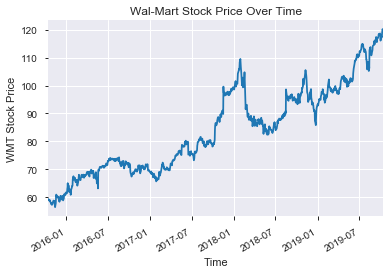

In [3]:
print(wmt_stock.head())
fig = plt.figure()

wmt_stock.plot()
plt.title("Wal-Mart Stock Price Over Time")
plt.xlabel("Time")
plt.ylabel('WMT Stock Price')
plt.show()


This function implements the Dickey-Fuller test and plots data along with rolling mean and standard deviation

In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    global dftest 
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    


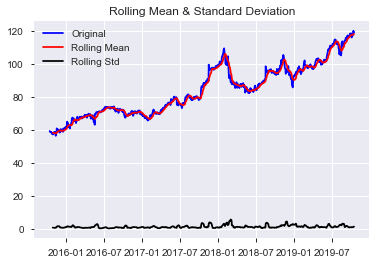

Results of Dickey-Fuller Test:
Test Statistic                   -0.419603
p-value                           0.906774
#Lags Used                        1.000000
Number of Observations Used    1004.000000
Critical Value (1%)              -3.436880
Critical Value (5%)              -2.864423
Critical Value (10%)             -2.568305
dtype: float64


In [5]:
test_stationarity(wmt_stock)

In [6]:
def test_stat_vs_crit_val():
    
    for key,value in dftest[4].items():
        if dftest[0] > value:
            print("The Test Statistic of", dftest[0], "is greater than the Critical Value", key, "value of", value)
        elif dftest[0] < value:
            print("The Test Statistic of", dftest[0], "is less than theCritical Value", key, "value of", value)

In [7]:
test_stat_vs_crit_val()

The Test Statistic of -0.41960301097381203 is greater than the Critical Value 1% value of -3.436879978012783
The Test Statistic of -0.41960301097381203 is greater than the Critical Value 5% value of -2.86442302475405
The Test Statistic of -0.41960301097381203 is greater than the Critical Value 10% value of -2.568305057578451


Now we will subtract the trend from our data to make it (more) stationary

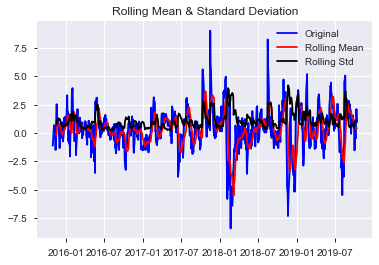

Results of Dickey-Fuller Test:
Test Statistic                -9.259355e+00
p-value                        1.420890e-15
#Lags Used                     0.000000e+00
Number of Observations Used    9.940000e+02
Critical Value (1%)           -3.436946e+00
Critical Value (5%)           -2.864452e+00
Critical Value (10%)          -2.568321e+00
dtype: float64


In [8]:
moving_avg = wmt_stock.rolling(12).mean()
no_trend = wmt_stock - moving_avg
plt.plot(no_trend)
plt.title("WMT Stock Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

In [9]:
test_stat_vs_crit_val()

The Test Statistic of -9.25935465944629 is less than theCritical Value 1% value of -3.43694584277544
The Test Statistic of -9.25935465944629 is less than theCritical Value 5% value of -2.8644520725172873
The Test Statistic of -9.25935465944629 is less than theCritical Value 10% value of -2.5683205291305176


Now we do a variable change from y to ln y.  Not that in python the "log" function is actually natural log, ln.  Also note that the test statistic did not change hardly at all, even though the series looks much better.  

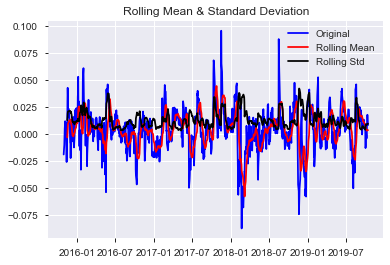

Results of Dickey-Fuller Test:
Test Statistic                -9.530086e+00
p-value                        2.906529e-16
#Lags Used                     0.000000e+00
Number of Observations Used    9.940000e+02
Critical Value (1%)           -3.436946e+00
Critical Value (5%)           -2.864452e+00
Critical Value (10%)          -2.568321e+00
dtype: float64


In [17]:
log_wmt_stock = np.log(wmt_stock)
log_moving_avg = log_wmt_stock.rolling(12).mean()
log_no_trend = log_wmt_stock - log_moving_avg
test_stationarity(log_no_trend.dropna())

In [11]:
test_stat_vs_crit_val()

The Test Statistic of -9.530086068900163 is less than theCritical Value 1% value of -3.43694584277544
The Test Statistic of -9.530086068900163 is less than theCritical Value 5% value of -2.8644520725172873
The Test Statistic of -9.530086068900163 is less than theCritical Value 10% value of -2.5683205291305176


This next set of charts simply shows all the pieces of the function.  

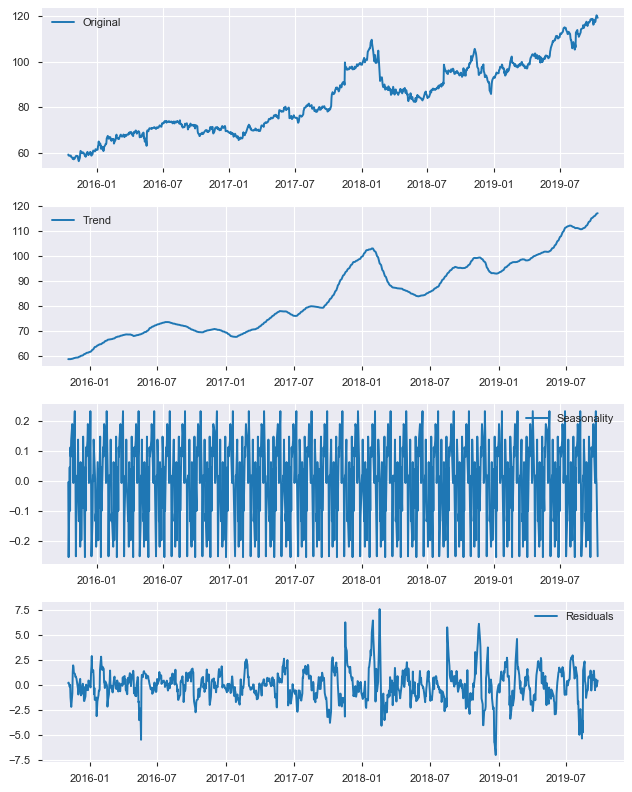

In [16]:
# from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(wmt_stock, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(wmt_stock, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Next we will try some differencing to try and eliminate seasonality and make the series further stationary.  This determines if we use a difference term or not.  In this example, 1 shift ($y_t - y_{t-1}$) is used, so d=1

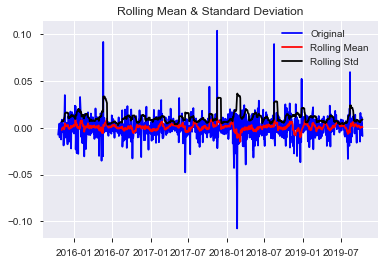

Results of Dickey-Fuller Test:
Test Statistic                  -33.555238
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1004.000000
Critical Value (1%)              -3.436880
Critical Value (5%)              -2.864423
Critical Value (10%)             -2.568305
dtype: float64


In [18]:
diff_wmt_stock = log_wmt_stock - log_wmt_stock.shift(1) # Changing the shift value is equivalent to changing your 'd' value
test_stationarity(diff_wmt_stock.dropna())

In [19]:
test_stat_vs_crit_val()

The Test Statistic of -33.555238204350225 is less than theCritical Value 1% value of -3.436879978012783
The Test Statistic of -33.555238204350225 is less than theCritical Value 5% value of -2.86442302475405
The Test Statistic of -33.555238204350225 is less than theCritical Value 10% value of -2.568305057578451


Now we take a look at the Autocorrelation and Partial Autocorrelation plots

Text(0.5, 1.0, 'Autocorrelation Function')

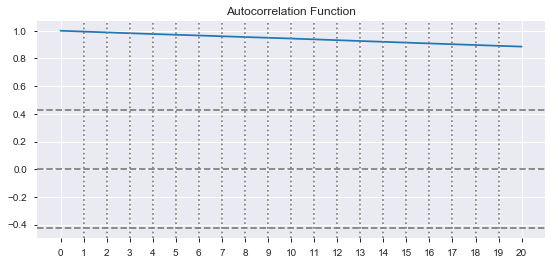

In [22]:
#from statsmodels.tsa.stattools import acf, pacf
acf_wmt_plot = acf(wmt_stock.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_wmt_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

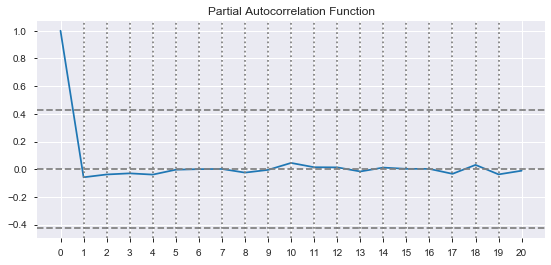

In [23]:
pacf_wmt_plot = pacf(diff_wmt_stock.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_wmt_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

Now we fit a model of the proper order and look at the output

**NOT IN OUR CASE: **

Since both the Autocorrelation and Partial Autocorrelation plots showed a drop at Lag 1 to within our confidence ranges - we'll start with a (1,0,1) ARIMA model.**  A (1,0,0) would likely fit equally well.

In [24]:
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1005
Model:                     ARMA(1, 0)   Log Likelihood                2997.749
Method:                       css-mle   S.D. of innovations              0.012
Date:                Fri, 18 Oct 2019   AIC                          -5989.497
Time:                        13:41:36   BIC                          -5974.759
Sample:                             0   HQIC                         -5983.897
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007      0.000      1.902      0.057   -2.11e-05       0.001
ar.L1.close    -0.0583      0.031     -1.851      0.064      -0.120       0.003
                                    Roots       

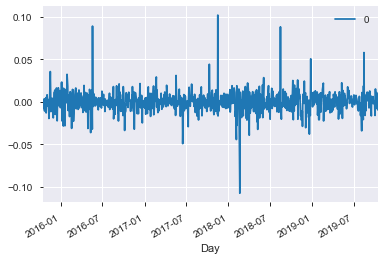

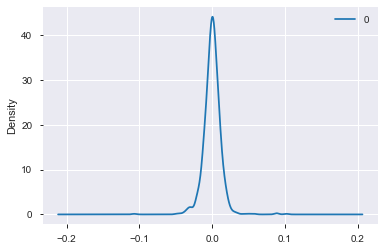

                  0
count  1.005000e+03
mean  -4.676807e-07
std    1.226168e-02
min   -1.072651e-01
25%   -5.923923e-03
50%    3.268284e-04
75%    5.899136e-03
max    1.018964e-01


In [29]:
model = ARIMA(diff_wmt_stock.dropna(), order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Now I am just going to do a brute force search for parameters and find the best  ones.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.38918557256972686


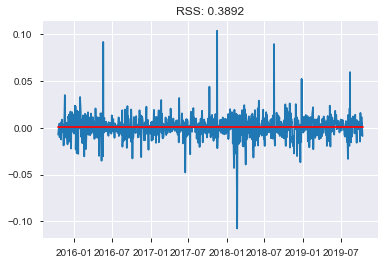

0 0 0
0.38846846972834553


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


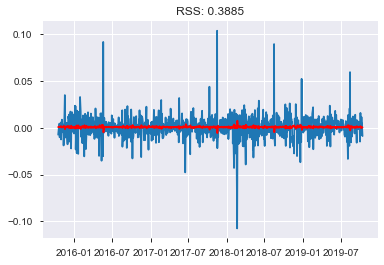

0 0 1
0.38816294443169175


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


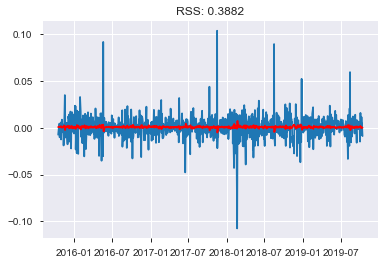

0 0 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


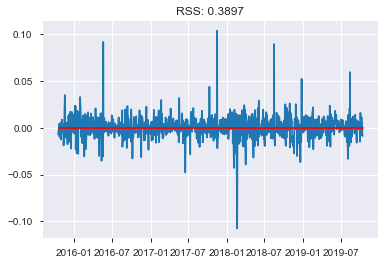

0 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


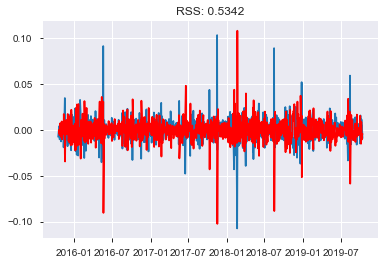

0 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


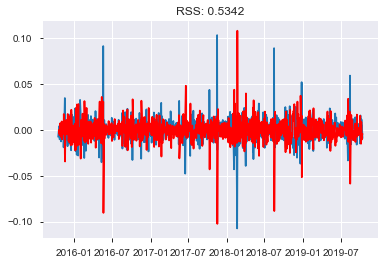

0 1 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


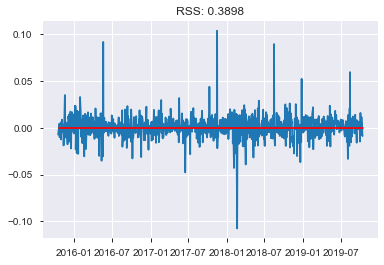

0 2 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


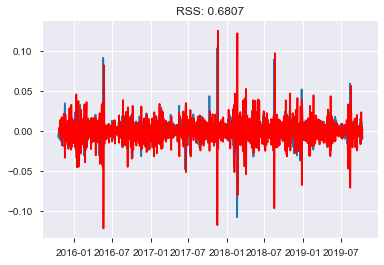

0 2 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


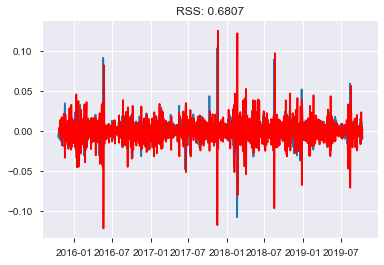

0 2 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


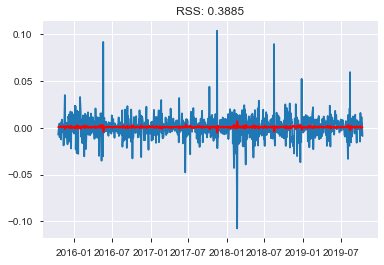

1 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.3878975678824028


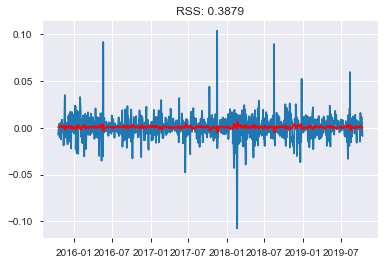

1 0 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


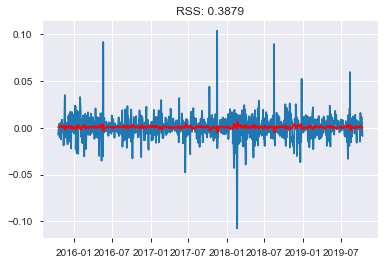

1 0 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


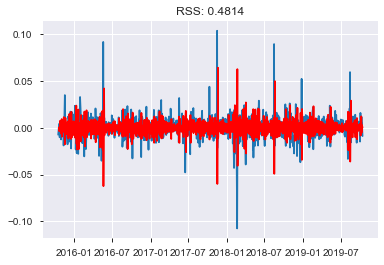

1 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


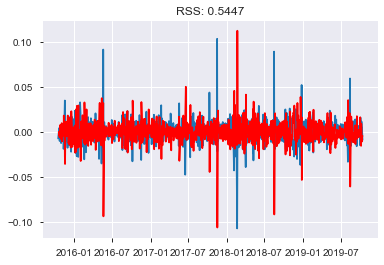

1 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


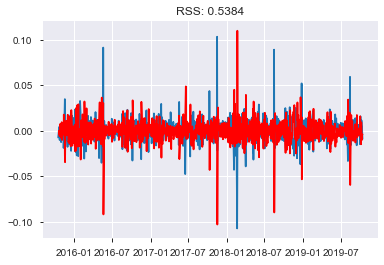

1 1 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


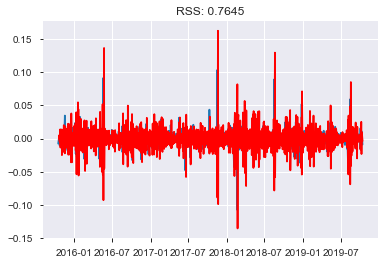

1 2 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


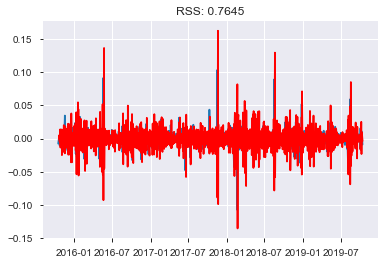

1 2 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


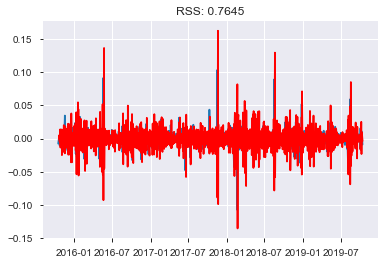

1 2 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


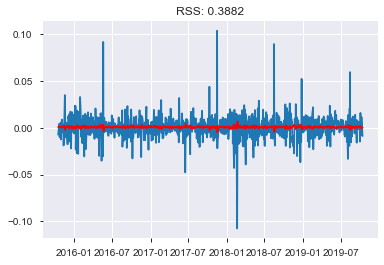

2 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.3878927088313136


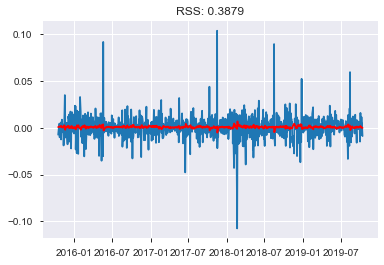

2 0 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


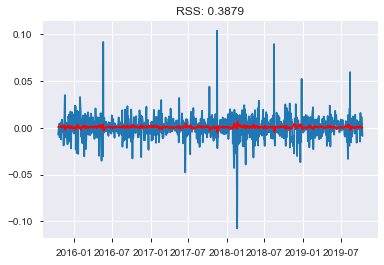

2 0 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


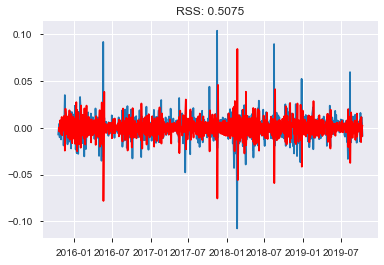

2 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


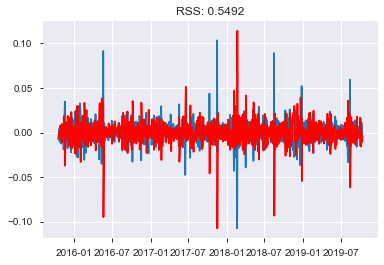

2 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


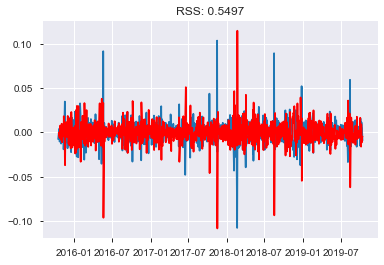

2 1 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


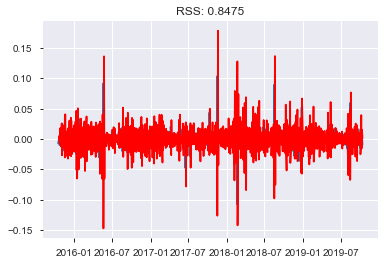

2 2 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


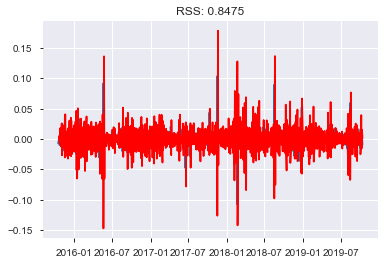

2 2 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


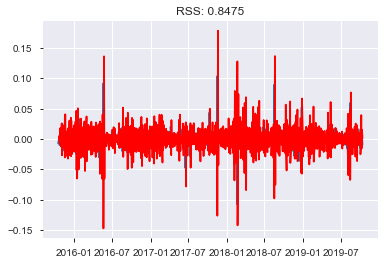

2 2 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


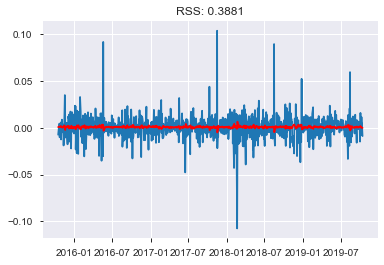

3 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.38786531683767067


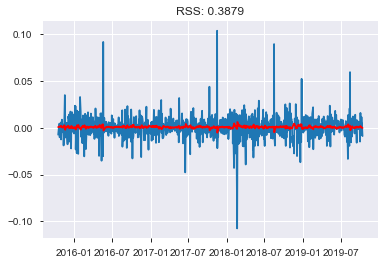

3 0 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


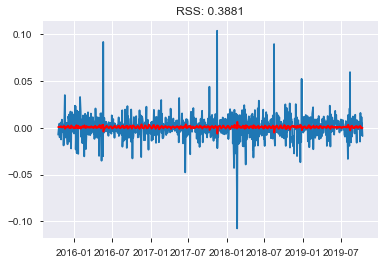

3 0 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


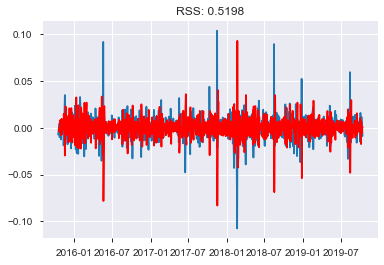

3 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


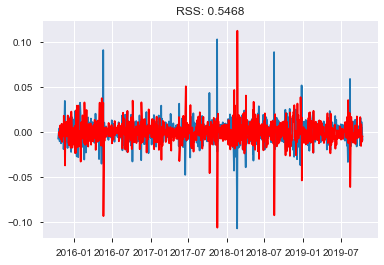

3 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


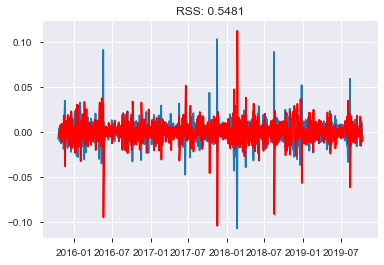

3 1 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


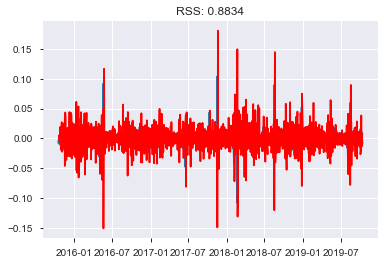

3 2 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


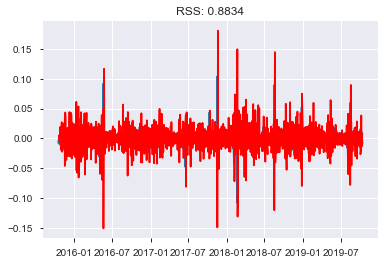

3 2 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


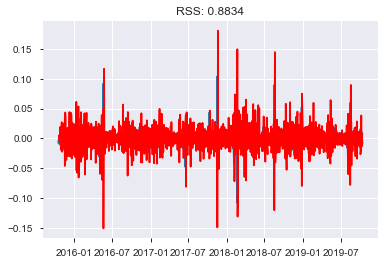

3 2 2


In [27]:
air_pop = wmt_stock.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff_wmt_stock.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff_wmt_stock)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff_wmt_stock)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [28]:
print(loss_best)
print(best_ints)

0.38786531683767067
[3, 0, 1]


In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
   for param_seasonal in seasonal_pdq:
       try:
           mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
           results = mod.fit()
           print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
       except:
           continue